In [18]:
# !pip install scikit-learn

In [1]:
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from tqdm import tqdm
import warnings
import numpy as np 
import matplotlib.pylab as plt
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## Evaluation Metrics

In [2]:
# tests
mil_res_0 = torch.load("../model_weights/mnst_mil_target_0/test_explain.pt")
mil_res_1 = torch.load("../model_weights/mnst_mil_target_1/test_explain.pt")
mil_res_2 = torch.load("../model_weights/mnst_mil_target_2/test_explain.pt")


transformer_res_0 = torch.load("../model_weights/mnst_transformer_target_0/test_explain.pt")
transformer_res_1 = torch.load("../model_weights/mnst_transformer_target_1/test_explain.pt")
transformer_res_2 = torch.load("../model_weights/mnst_transformer_target_2/test_explain.pt")

In [3]:
mil_res_0.keys()

dict_keys(['true_label', 'pred_label', 'masks', 'batch_indices', 'attention_scores'])

In [4]:
mil_tests = [mil_res_0, mil_res_1, mil_res_2]
transformer_test = [transformer_res_0, transformer_res_1, transformer_res_2]
mil_accuracy = []
for t in mil_tests:
    print("f1 ", f1_score(t["true_label"], t["pred_label"]))
    mil_accuracy.append(accuracy_score(t["true_label"], t["pred_label"]))
    print("accuracy ", accuracy_score(t["true_label"], t["pred_label"]))

f1  0.9819822376074682
accuracy  0.98015625
f1  0.9348265671177477
accuracy  0.9214375
f1  0.8159896771418587
accuracy  0.78609375


In [5]:
transformer_accuracy = []
for t in transformer_test:
    print("f1 ", f1_score(t["true_label"], t["pred_label"]))
    transformer_accuracy.append(accuracy_score(t["true_label"], t["pred_label"]))
    print("accuracy ", accuracy_score(t["true_label"], t["pred_label"]))

f1  0.9796263897511146
accuracy  0.9774375
f1  0.9710167714884697
accuracy  0.9654375
f1  0.9797124030252865
accuracy  0.98046875


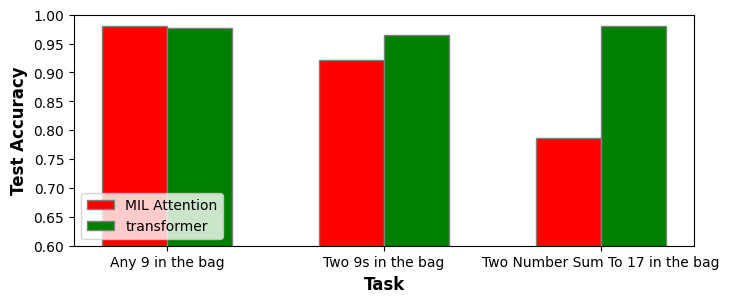

In [6]:
barWidth = 0.3
fig = plt.subplots(figsize =(8, 3)) 

br1 = np.arange(len(mil_accuracy)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, mil_accuracy, color ='r', width = barWidth, 
        edgecolor ='grey', label ='MIL Attention') 
plt.bar(br2, transformer_accuracy, color ='g', width = barWidth, 
        edgecolor ='grey', label ='transformer') 

plt.ylim([0.6, 1])

plt.xlabel('Task', fontweight ='bold', fontsize = 12) 
plt.ylabel('Test Accuracy', fontweight ='bold', fontsize = 12) 
plt.xticks([r + 0.5 * barWidth for r in range(len(mil_accuracy))], 
        ['Any 9 in the bag', 'Two 9s in the bag', 'Two Number Sum To 17 in the bag'])

plt.legend(loc='lower left')
plt.show() 

## Attention weights explainability

In [7]:
## Download MNST test images
dataset = datasets.MNIST('../datasets',
                      train=False,
                      download=True,
                      transform=None)

In [42]:
def transformer_attention_agg(attn, agg_fn="mean"):
    n_heads, n_seq, n_seq = attn.shape
    cls_attn = attn[:, 0, 1:]
    if agg_fn == "mean":
        return torch.mean(cls_attn.view(n_heads, n_seq - 1), 0)
    elif agg_fn == "max":
        return torch.max(cls_attn.view(n_heads, n_seq - 1), 0).values()
    elif agg_fn == "quantile":
        return torch.quantile(cls_attn.view(n_heads, n_seq - 1), 0.90, 0)
    else:
        return torch.mean(cls_attn.view(n_heads, n_seq - 1), 0)

def plot_scores(row, test_results, is_transformer=False, label_meaning="The bag has target 9", agg_fn="mean", show_title=True):
    batch_indices = test_results["batch_indices"][row]
    imgs = [dataset[i_][0] for i_ in batch_indices]
    labels = [dataset[i_][1] for i_ in batch_indices]
    true_label = test_results["true_label"][row]
    pred_label = test_results["pred_label"][row]
    n = int(torch.sum(test_results["masks"][row]))
    n_cols = 6
    n_rows = (n + n_cols - 1) // n_cols 
    if is_transformer:
        scores = transformer_attention_agg(test_results["attention_scores"][row], agg_fn=agg_fn)
    else:
        scores = test_results["attention_scores"][row][0]
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figwidth(15)
    fig.set_figheight(int(12/4 * n_rows))
    title = label_meaning + "\n" + "Ground Truth: %r || Model Pred: %r"%(bool(true_label), bool(pred_label))
    if show_title: 
        fig.suptitle(title)
    for i in range(n_cols * n_rows):
        if i < n:
            if(n_rows == 1):
                ax[i%n_cols].imshow(imgs[i])
                if show_title:
                    ax[i%n_cols].set_title("attn score %0.2f"%(scores[i]))
                ax[i%n_cols].axis("off")
            else:
                ax[i//n_cols][i%n_cols].imshow(imgs[i])
                if show_title:
                    ax[i//n_cols][i%n_cols].set_title("attn score %0.2f"%(scores[i]))
                ax[i//n_cols][i%n_cols].axis("off")
        else:
            if(n_rows == 1):
                ax[i%n_cols].axis('off')
            else:
                ax[i//n_cols][i%n_cols].axis('off')

## MIL 

In [19]:
# plot_scores(0, mil_res_0), \
# plot_scores(1, mil_res_0), \
# plot_scores(2, mil_res_0)

In [18]:
# plot_scores(0, mil_res_1, label_meaning="The bag has two 9s"), \
# plot_scores(1, mil_res_1, label_meaning="The bag has two 9s"), \
# plot_scores(2, mil_res_1, label_meaning="The bag has two 9s")

In [17]:
# plot_scores(0, mil_res_2, label_meaning="The bag has two number sums to 17"), \
# plot_scores(1, mil_res_2, label_meaning="The bag has two number sums to 17"), \
# plot_scores(2, mil_res_2, label_meaning="The bag has two number sums to 17")

## Transformer

In [16]:
# plot_scores(0, transformer_res_0, is_transformer=True), \
# plot_scores(1, transformer_res_0, is_transformer=True), \
# plot_scores(2, transformer_res_0, is_transformer=True)

In [15]:
# plot_scores(0, transformer_res_1, is_transformer=True, label_meaning="The bag has two 9s"), \
# plot_scores(1, transformer_res_1, is_transformer=True, label_meaning="The bag has two 9s"), \
# plot_scores(2, transformer_res_1, is_transformer=True, label_meaning="The bag has two 9s")

In [14]:
# plot_scores(0, transformer_res_2, is_transformer=True, label_meaning="The bag has two number sums to 17"), \
# plot_scores(1, transformer_res_2, is_transformer=True, label_meaning="The bag has two number sums to 17"), \
# plot_scores(2, transformer_res_2, is_transformer=True, label_meaning="The bag has two number sums to 17")

In [21]:
mil_res_0.keys()

dict_keys(['true_label', 'pred_label', 'masks', 'batch_indices', 'attention_scores'])

In [44]:
t1_mil_label = mil_res_0["true_label"]
t1_mil_pred = mil_res_0["pred_label"]
t1_trans_pred = transformer_res_0["pred_label"]
np.arange(mil_res_0["masks"].shape[0])[(torch.sum(mil_res_0["masks"], 1) == 6).numpy()]

array([   10,    13,    16, ..., 31957, 31963, 31976])

In [45]:
# row = 10 
# plot_scores(row, mil_res_0, label_meaning=""), \
# plot_scores(row, transformer_res_0, is_transformer=True, label_meaning="")

In [79]:
t2_mil_label = mil_res_1["true_label"]
t2_mil_pred = mil_res_1["pred_label"]
t2_trans_pred = transformer_res_1["pred_label"]

filter_index = (torch.sum(mil_res_1["masks"], 1) == 18).numpy() & \
                (t2_mil_label != t2_mil_pred).numpy() & \
                (t2_mil_label == t2_trans_pred).numpy() & \
                (t2_mil_label == 1).numpy()
indices_all = np.arange(mil_res_1["masks"].shape[0])
indices_all[filter_index]

array([ 2270,  3247,  3349,  4374,  4967,  9074,  9934, 10641, 11781,
       16394, 16624, 19114, 19672, 20547, 21056, 21732, 24485, 25557,
       26225, 29662])

(None, None)

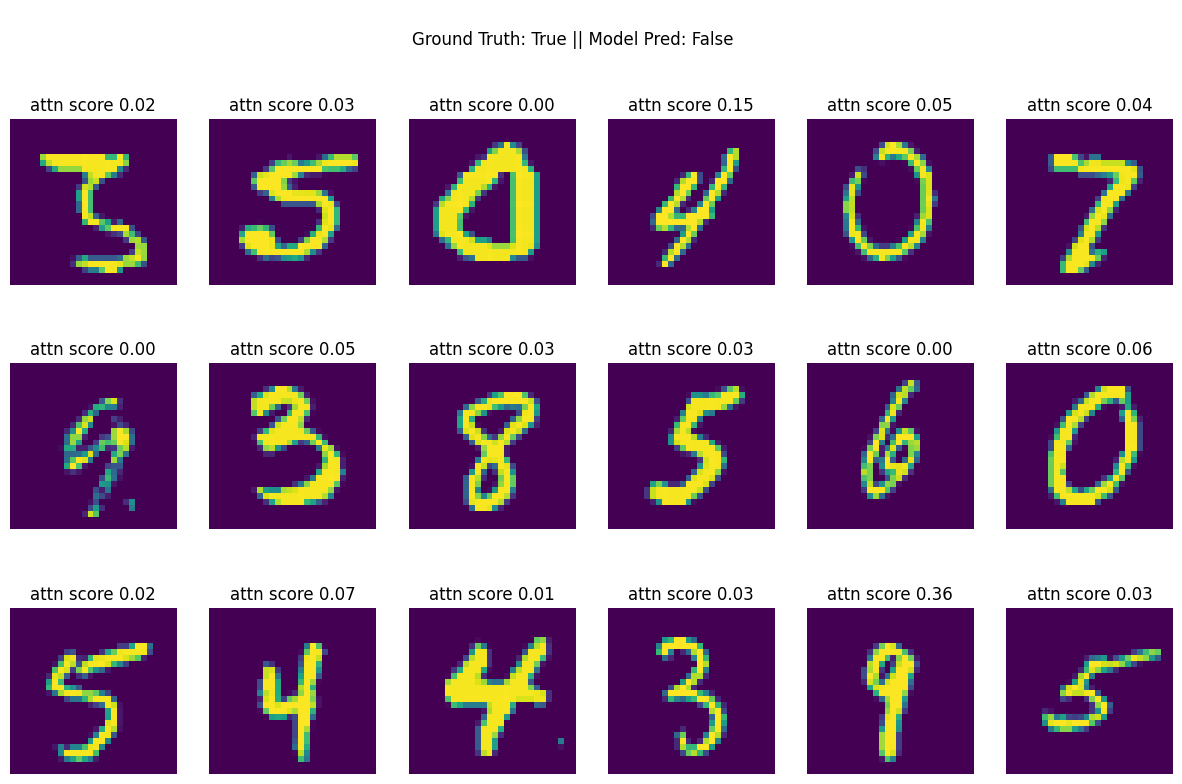

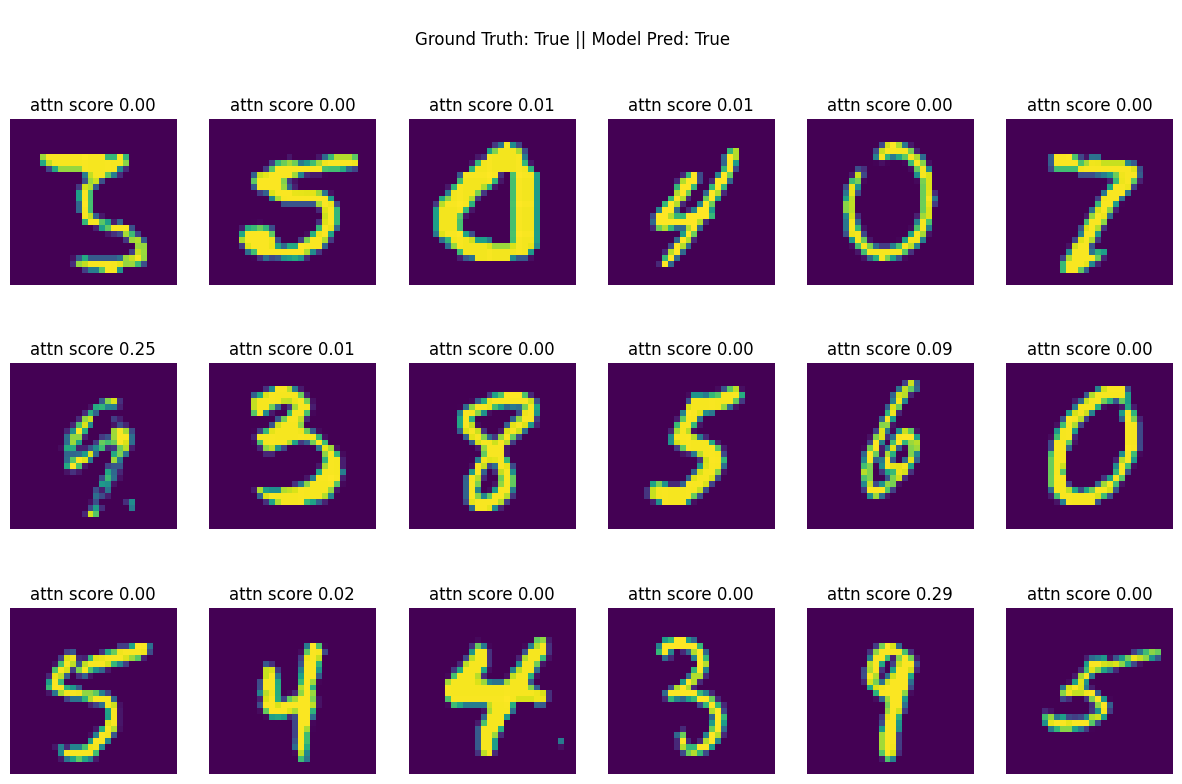

In [82]:
row = 3349 
plot_scores(row, mil_res_1, label_meaning=""), \
plot_scores(row, transformer_res_1, is_transformer=True, label_meaning="")

In [69]:
t3_mil_label = mil_res_2["true_label"]
t3_mil_pred = mil_res_2["pred_label"]
t3_trans_pred = transformer_res_2["pred_label"]

filter_index = (torch.sum(mil_res_2["masks"], 1) == 12).numpy() & \
                (t3_mil_label != t3_mil_pred).numpy() & \
                (t3_mil_label == t3_trans_pred).numpy() & \
                (t3_mil_label == 1).numpy()
indices_all = np.arange(mil_res_2["masks"].shape[0])
indices_all[filter_index]

array([ 1576,  2351,  4854,  5957,  7318,  7354,  8797,  9186, 12218,
       13139, 13783, 16097, 16111, 16355, 17235, 18643, 19964, 19986,
       20530, 20614, 21104, 22245, 22470, 22805, 24321, 24907, 25871,
       29425])

In [71]:
# row = 1576 
# plot_scores(row, mil_res_2, label_meaning=""), \
# plot_scores(row, transformer_res_2, is_transformer=True, label_meaning="")